In [1]:
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf

In [3]:
import threading
import os
import cPickle as pickle
import logging
import pprint
import glob
import collections
import struct
import json
logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p', level=logging.INFO)


In [4]:
logging.info('abc')

08/15/2017 10:45:08 PM INFO: abc


In [5]:
class GeneratorRunner(object):
    "Custom runner that that runs an generator in a thread and enqueues the outputs."

    def __init__(self, generator, placeholders, enqueue_op, close_op):
        self._generator = generator
        self._placeholders = placeholders
        self._enqueue_op = enqueue_op
        self._close_op = close_op

    def _run(self, sess, coord):
        try:
            while not coord.should_stop():
                try:
                    values = next(self._generator)

                    assert len(values) == len(self._placeholders), \
                        'generator values and placeholders must have the same length'

                    feed_dict = {placeholder: value \
                        for placeholder, value in zip(self._placeholders, values)}
                    sess.run(self._enqueue_op, feed_dict=feed_dict)
                except (StopIteration, tf.errors.OutOfRangeError, tf.errors.DeadlineExceededError, tf.errors.CancelledError) as e:
                    logging.warning ("%s %s %s", self.__class__.__name__, "exception:", str(type(e)))
                    try:
                        sess.run(self._close_op)
                    except Exception:
                        pass
                    return
        except Exception as ex:
            if coord:
                logging.info ("%s %s %s %s", self.__class__.__name__, "request stop from", self._run.__name__, str(ex))
                coord.request_stop(ex)
                pass
            else: 
                raise

    def create_threads(self, sess, coord=None, daemon=False, start=False):
        "Called by `start_queue_runners`."

        thread = threading.Thread(
            target=self._run,
            args=(sess, coord))

        if coord:
            coord.register_thread(thread)

        if daemon:
            thread.daemon = True

        if start:
            thread.start()

        return [thread]

def read_batch_generator(
        generator, dtypes, shapes, batch_size,
        queue_capacity=10000,
        allow_smaller_final_batch=False):
    "Reads values from an generator, queues, and batches."

    assert len(dtypes) == len(shapes), 'dtypes and shapes must have the same length'
    logging.info('shapes: %s, types: %s, batchsize: %d', str(shapes), str(dtypes), batch_size)
    queue = tf.FIFOQueue(
        capacity=queue_capacity,
        dtypes=dtypes,
        shapes=shapes)

    placeholders = [tf.placeholder(dtype, shape) for dtype, shape in zip(dtypes, shapes)]

    enqueue_op = queue.enqueue(placeholders)
    close_op = queue.close(cancel_pending_enqueues=True)
    global_close_ops.append(close_op)
    queue_runner = GeneratorRunner(generator, placeholders, enqueue_op, close_op)
    tf.train.add_queue_runner(queue_runner)

    if allow_smaller_final_batch:
        return queue.dequeue_up_to(batch_size)
    else:
        return queue.dequeue_many(batch_size)    

In [6]:
LEN1=64*2
import Queue,random
class MemoryGenerator(object):
    def __init__(self, daily_data,attrib_data, epochs=np.inf):
        self.daily_data = daily_data
        self.attrib_data = attrib_data        
        self.shuffle=True
        self.epochs = epochs
        self.N = len(self.daily_data)*10
        self.curr_epoch = 1
        self.curr_i = 0
        self.q = Queue.Queue()
        if self.shuffle:
            self.do_shuffle()
    def __iter__(self):
        return self
    def do_shuffle(self):
        idx = np.random.permutation(range(len(self.daily_data)))
        self.daily_data = self.daily_data[idx]     
        self.attrib_data = self.attrib_data[idx]
    def fill_queue(self):
        for _ in range(100):
            i=int(np.random.random()*len(self.daily_data))
            attrib_row=self.attrib_data[i]
            row=self.daily_data[i]
            len1=LEN1
            len2=60
            j= random.randint(len1,len(row)-1)
            x=row[j-len1:j]
            part_y=row[j:j+len2]
            y=np.zeros(len2,dtype=np.float32)
            y[:len(part_y)]=part_y
            mask=np.zeros(len2,dtype=np.float32)
            mask[:len(part_y)]= (part_y!=0)*1
            self.q.put((x.astype(np.float32),attrib_row.astype(np.float32),np.array(y,dtype=np.float32),mask))
    def __next__(self):
        return self.next()
    def next(self):
        if self.curr_i >= self.N:
            self.curr_i = 0
            self.curr_epoch += 1
            if self.curr_epoch > self.epochs: raise StopIteration
            if self.shuffle: 
                self.do_shuffle()
        if self.q.empty(): self.fill_queue()
        X1,X2, y,mask = self.q.get()
        self.curr_i += 1
        return X1,X2, y,mask 


In [7]:
def make_train_readers(daily_data,attrib_data, nrows=None, batchsize=60):
    print daily_data.shape, attrib_data.shape
    train_generator = MemoryGenerator(daily_data,attrib_data)
    return read_batch_generator(train_generator, [tf.float32, tf.float32, tf.float32, tf.float32], 
                                [(LEN1,), (12,), (60,),(60,)], batchsize, allow_smaller_final_batch=True),train_generator

In [8]:
locales=sorted([u'en', u'ja', u'de', u'fr', u'zh', u'ru', u'es'])
locale_map={v:u for u,v in enumerate(locales)}
locale_map

{u'de': 0, u'en': 1, u'es': 2, u'fr': 3, u'ja': 4, u'ru': 5, u'zh': 6}

In [9]:
access_map={u'all-access':0, u'mobile-web':1, u'desktop':2}
agent_map={u'all-agents':0, u'spider':1}
access_map,agent_map

({u'all-access': 0, u'desktop': 2, u'mobile-web': 1},
 {u'all-agents': 0, u'spider': 1})

In [10]:
def f_map(series, data_map):
    lst=[]
    keys=list(data_map.keys())
    for k in keys:
        lst.append(series.map(lambda u: (u==k)*1))
    df=pd.concat(lst,axis=1)
    df.columns=[series.name+"_"+u for u in keys]
    return df

In [11]:
def make_data():
    import pandas as pd
    csv_path="../input/newtrain_1.csv"
    data = pd.read_csv(csv_path, nrows=None)
    datecols=[u for u in data.columns if u.startswith("20")][-256:]
    daily_data=data[datecols].values.astype(np.float32)
    attrib_data=pd.concat([f_map(data.locale,locale_map),
                           f_map(data.agent,agent_map),
                           f_map(data.access,access_map)],axis=1).values.astype(np.float32)    
    print daily_data.shape,attrib_data.shape
    return daily_data,attrib_data

In [12]:
daily_data,attrib_data=make_data()

(145063, 256) (145063, 12)


In [13]:
print np.mean(daily_data==0)
#daily_data += (daily_data==0)*0.1
#print np.mean(daily_data==0)

0.0564550240671


In [14]:
if 0:
    global_close_ops = []
    #daily_data,attrib_data=make_data()
    _, generator=make_train_readers(daily_data,attrib_data)
    a,b,c,d= generator.next()
    #print a,b,c,d    
    print a.shape,b.shape,c.shape,d.shape


In [15]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>" % size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    from IPython.display import clear_output, Image, display, HTML

    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph' + str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))


In [16]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def dense(x, size, scope, with_activation=True):
    if 1:
        with tf.variable_scope(scope):
            w = weight_variable(shape=[int(x.get_shape()[-1]), size], name=None)
            b = bias_variable(shape=[size], name=None)
            h1 = tf.matmul(x, w) + b
            layer=tf.sigmoid(h1) if with_activation else h1
            print layer.get_shape()
    return layer,w,b
from tensorflow.contrib import rnn
def lstm(x,x2, n_hiddens, n_input, n_output, scope):
    if 1:
        with tf.variable_scope(scope):
            x = tf.reshape(x, [-1, n_input])
            x = tf.split(x,n_input,1)
            basic_rnn_cells = [rnn.BasicLSTMCell(n_hidden) for n_hidden in n_hiddens]
            rnn_cell = rnn.MultiRNNCell(basic_rnn_cells)
            outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32) 
            concat_x=tf.concat([outputs[-1],x2],-1)
            print outputs[-1].get_shape(), concat_x.get_shape()             
            return concat_x

def get_Xy(x_size,x2_size,y_size):
    X = tf.placeholder("float", shape=[None, x_size], name='input_x')
    X2 = tf.placeholder("float", shape=[None, x2_size], name='input_x2')    
    l2_scale = tf.placeholder(tf.float32, name='l2_scale')
    y = tf.placeholder("float", shape=[None, y_size], name='input_y')
    mask = tf.placeholder("float", shape=[None, y_size], name='mask')
    return X,X2, y,mask, l2_scale

In [25]:
class MyModel(object):
    def __init__(self, x_size,y_size, n_hiddens,l2_scale,phase=True ):
        self.phase=phase
        n_hiddens=n_hiddens
        self.graph = tf.Graph()
        self.all_denses = []
        with self.graph.as_default(): 
            self.X, self.X2, self.y, self.mask, self.l2_scale = get_Xy(x_size,12, y_size)
            assert(x_size == self.X.get_shape()[1])
            with tf.variable_scope("nodes"):
                self.X, self.y, self.loss, self.smape \
                     = self.make_model(x_size=x_size, y_size=y_size, n_hiddens=n_hiddens)

            
            with tf.variable_scope('saver'):
                    self.saver = tf.train.Saver()

            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.variable_scope('optimizer'):
                with tf.control_dependencies(update_ops):
                    self.optimizer = tf.train.AdamOptimizer()#.minimize(self.loss)
                    gvs = self.optimizer.compute_gradients(self.loss)
                    capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
                    self.train_op = self.optimizer.apply_gradients(capped_gvs)
        self._session = None    
    @property
    def session(self): 
        if self._session is None:
            config = tf.ConfigProto(log_device_placement=True)
            config.gpu_options.per_process_gpu_memory_fraction = 0.5  # don't hog all vRAM
            self._session = tf.Session(graph=self.graph,config=config)
        return self._session
    
    def close_session(self):
        if self._session is not None:
            self._session.close()
            self._session = None
    def initialize(self, session=None):
        with self.graph.as_default():
            init_op = tf.global_variables_initializer()        
        self.session.run(init_op) 
        return self.session
 
        
    def make_model(self, x_size,y_size, n_hiddens):
        X_raw, y  = self.X, self.y 
        logging.debug ("%s %s", self.__class__.__name__,
                       'input shapes: X={},y={}'.format(X_raw.get_shape(), None if y is None else y.get_shape()))

        h=X_raw
        #h = tf.log(X_raw+1)
        #h=     tf.layers.batch_normalization(h,center=False, scale=True,training=self.phase)
        
        h=lstm(h,self.X2, [n_hiddens[0]], x_size, y_size, 'lstm')
        for i in range(0, len(n_hiddens)):
            n_hidden = n_hiddens[i]
            h, w,b = dense(h, n_hidden,'dense')
            self.all_denses.append((h,w,b))

        logits_sum,_,_=dense(h,y_size,'dense',with_activation=False)
        
        with tf.variable_scope("loss"):
            epsilon = 1e-7        
            l2_loss = 0
            if 1:  # self.l2_scale > 0:
                logging.info('use l2 reg scale %s', str(self.l2_scale))
                for _,w,_ in self.all_denses:
                    l2_loss = l2_loss + tf.reduce_sum(w ** 2)
                l2_loss = l2_loss * self.l2_scale
                self.l2_loss = l2_loss
            if 1:
                predictions = tf.identity(logits_sum, name='prediction')
                float_labels = tf.cast(y, tf.float32)
                
                ratio=predictions/(float_labels+1e-4)
                additional_loss= 0.02*tf.cast(ratio>9,tf.float32)*tf.abs(ratio)\
                    +0.02*tf.cast(predictions<0.0,tf.float32)*tf.abs(predictions)
                additional_loss = tf.reduce_sum(additional_loss*self.mask)/tf.reduce_sum(self.mask)
                this_loss =  tf.abs(predictions-float_labels)/(tf.abs(predictions)+tf.abs(float_labels))
                this_loss=this_loss*self.mask
                this_loss = tf.identity(2* tf.reduce_sum(this_loss)/tf.reduce_sum(self.mask), name='smape') 
                #that_loss=tf.reduce_mean((predictions-float_labels)**2)
                loss = this_loss + l2_loss+additional_loss

            logging.info ('%s %s %s', self.__class__.__name__, 'logits shape', logits_sum.get_shape())

        return X_raw, y, loss, this_loss
 
    
    def save(self, prefix, ckpt=1):
        checkpoint_name = '{}/model_{}'.format(prefix, 0)
        self.saver.save(self.session, checkpoint_name, global_step=ckpt)

    def load(self, prefix, ckpt=1):
        self.saver.restore(self.session, '{}/model_{}-{}'.format(prefix, self.model_id, ckpt))


In [26]:
if 0:
    tf.reset_default_graph()
    model = MyModel(x_size=5, y_size=2, n_hiddens=[2,2], l2_scale=0.1)
    model.initialize()
    #print [n.op for n in model.graph.as_graph_def().node];
    show_graph(model.graph.as_graph_def())

In [27]:
def svd_orthonormal(shape):
    print(shape)
    if len(shape) < 2:
        raise RuntimeError("Only shapes of length 2 or more are supported.")
    flat_shape = (shape[0], np.prod(shape[1:]))
    a = np.random.standard_normal(flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.reshape(shape)
    return q

def get_activations(model, h, X_batch):
    activations = model.session.run(h, feed_dict={model.X:X_batch})
    return activations

def LSUVinit(model, batch):
    # only these layer classes considered for LSUV initialization; add more if needed    
    margin = 0.1
    max_iter = 10
    layers_inintialized = 0
    for h,w,_ in model.all_denses:
        # avoid small layers where activation variance close to zero, esp. for small batches
        if np.prod(h.get_shape()) < 32:
            print(h, 'too small')
            continue
        logging.info('LSUV initializing' + str(h))
        layers_inintialized += 1
        needed_variance = 1.0
        
        # print ('pre',np.sum(model.session.run(np.abs(w))))
        weights = svd_orthonormal(w.get_shape())
        model.session.run(tf.assign(w, weights))
        # print (model.session.run(w),weights)
        # print ('post',np.sum(model.session.run(np.abs(w))),np.sum(np.abs(weights)))        
        acts1 = get_activations(model, h, batch)
        # print (acts1,needed_variance)
        
        var1 = np.var(acts1)
        iter1 = 0
        logging.info('var1 %f', var1)
        while (abs(needed_variance - var1) > margin):
            if np.abs(np.sqrt(var1)) < 1e-7: break  # avoid zero division
            weights /= np.sqrt(var1) / np.sqrt(needed_variance)
            model.session.run(tf.assign(w, weights))
            acts1 = get_activations(model, h, batch)
            var1 = np.var(acts1)
            iter1 += 1
            # print (acts1)
            logging.info('var1 %f', var1)
            if iter1 > max_iter:
                break
    logging.info('LSUV: total layers initialized %d', layers_inintialized)   
    return model


In [28]:

class BN(object):
    def __init__(self, x_size, y_size, n_hiddens, l2_scale=0.0, prefix='./tmp'):
        self.x_size = x_size
        self.y_size=y_size
        self.n_hiddens = n_hiddens
        self.l2_scale = l2_scale
        self.prefix = prefix
    

    def train_one_epoch(self, n_epoch, sess, model, train_reader,test_reader, coord):
        count = 0
        loss = []; l2_loss = []
        while not coord.should_stop():
            try:
                if  True:
                    X,X2, y,mask = sess.run(train_reader)
                    feed_dict = {model.X:X, model.X2:X2, model.y:y, model.mask:mask, model.l2_scale: self.l2_scale}
                    _, a, aa = model.session.run([model.train_op, model.loss, model.smape], 
                                                    feed_dict=feed_dict)
                    loss.append(a)
                    l2_loss.append(aa)
                    count += len(y)
                    if count % self.net_train_report_intev == 0:

                        logging.info ('[epoch {}][step {}] AVG LOSS: {}, smape: {}'.format(
                            n_epoch, count, np.mean(loss), np.mean(l2_loss)))
                        loss = []; l2_loss = []
                        #self.read_params()

                    if count >= self.net_train_eval_intev:
                        X,X2, y,mask = sess.run(test_reader)
                        feed_dict = {model.X:X, model.X2:X2, model.y:y, model.mask:mask, model.l2_scale: self.l2_scale}
                        a, aa = model.session.run([ model.loss, model.smape], 
                                                    feed_dict=feed_dict)
                        logging.info ('[epoch {}] Valid LOSS: {}, smape: {}'.format(
                            n_epoch, a, aa))
                        return 0
            except tf.errors.OutOfRangeError:
                logging.info (self.__class__.__name__, 'Done with read')
                logging.info (self.__class__.__name__, "request stop from", self.train_one_epoch.__name__)                
                coord.request_stop()
                for o in global_close_ops: sess.run(o)
                return 1                                      
            except:
                raise           
        return 0


    def save_net(self, sess, model, n_epoch):
        model.save(prefix=self.prefix, ckpt=n_epoch)

    def train(self, daily_data,attrib_data, net_round,net_train_report_intev,net_train_eval_intev):
        self.net_train_report_intev=net_train_report_intev
        self.net_train_eval_intev=net_train_eval_intev
        model = MyModel(x_size=self.x_size, y_size=self.y_size, n_hiddens=self.n_hiddens,
                             l2_scale=self.l2_scale)
        model.initialize()
        config = tf.ConfigProto(log_device_placement=True)
        config.gpu_options.per_process_gpu_memory_fraction = 0.5  # don't hog all vRAM
        # config.operation_timeout_in_ms = 10000  # terminate on long hangs
        idx=np.random.permutation(range(len(daily_data)))
        trainidx=idx[:int(len(idx)*0.8)]
        testidx=idx[int(len(idx)*0.8):]
        train_daily_data=daily_data[trainidx]
        train_attrib_data=attrib_data[trainidx]
        test_daily_data=daily_data[testidx]
        test_attrib_data=attrib_data[testidx] 
        print train_daily_data.shape,test_daily_data.shape
        with tf.Session(config=config) as sess:
            train_reader,_ = make_train_readers(train_daily_data,train_attrib_data,batchsize=batch_size,nrows=None)            
            test_reader,_ = make_train_readers(test_daily_data,test_attrib_data,batchsize=batch_size*20,nrows=None)            
            
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(sess=sess, coord=coord)
            res = None
            try:
                if 0:
                    logging.info('Use LSUV initialization')
                    batch = np.concatenate([sess.run(train_reader)[0] for _ in range(100)])
                    LSUVinit(model, batch)
                for j in range(net_round):
                    logging.info ('[epoch {}] start net training'.format(j))
                    if self.train_one_epoch(j, sess, model, train_reader, test_reader,coord) is None:
                        raise Exception("train error") 
                    self.save_net(sess=sess, model=model, n_epoch=0)
            except:
                raise 
            finally:
                logging.info ('%s %s %s', self.__class__.__name__, "request stop from", self.train.__name__)
                for o in global_close_ops: sess.run(o)                
                coord.request_stop()

            coord.join(threads)
            sess.close()
            model.close_session()
            return 

    def read_params(self):
	try:
	    with open('param.txt') as f:
	        m = json.load(f)
 	    a = m["l2_scale"]
	    if self.l2_scale != a: 
		logging.info("Change l2_scale from %e to %e", self.l2_scale, a)
	     	self.l2_scale = a
	except:
	    logging.error('read params failed')


In [29]:
daily_data.shape

(145063, 256)

In [30]:
l2_scale = 1e-8*0

batch_size = 256

if 0: #test
    n_hiddens=[10]
    net_round=10
    net_train_report_intev=batch_size*10
    net_train_eval_intev=10000
else:
    n_hiddens=[512,512]    
    net_round=200
    net_train_report_intev=batch_size*100
    net_train_eval_intev=batch_size*1000

In [31]:
global_close_ops = []
tf.reset_default_graph()       
model = BN(x_size=LEN1, y_size=60, n_hiddens=n_hiddens, prefix='tmp_pred60_lstm_512_nozero_xnopad_nolog', l2_scale=l2_scale)
model.train(daily_data,attrib_data,  \
           net_round=net_round,  net_train_report_intev=net_train_report_intev,
            net_train_eval_intev=net_train_eval_intev )  

08/15/2017 10:49:17 PM INFO: use l2 reg scale Tensor("l2_scale:0", dtype=float32)
08/15/2017 10:49:17 PM INFO: MyModel logits shape (?, 60)


(?, 512) (?, 524)
(?, 512)
(?, 512)
(?, 60)


08/15/2017 10:49:29 PM INFO: shapes: [(128,), (12,), (60,), (60,)], types: [tf.float32, tf.float32, tf.float32, tf.float32], batchsize: 256
08/15/2017 10:49:29 PM INFO: shapes: [(128,), (12,), (60,), (60,)], types: [tf.float32, tf.float32, tf.float32, tf.float32], batchsize: 5120
08/15/2017 10:49:29 PM INFO: [epoch 0] start net training


(116050, 256) (29013, 256)
(116050, 256) (116050, 12)
(29013, 256) (29013, 12)


08/15/2017 10:49:55 PM INFO: [epoch 0][step 25600] AVG LOSS: 1.46541714668, smape: 1.46196627617
08/15/2017 10:50:14 PM INFO: [epoch 0][step 51200] AVG LOSS: 1.19931054115, smape: 1.19902336597
08/15/2017 10:50:34 PM INFO: [epoch 0][step 76800] AVG LOSS: 1.09515500069, smape: 1.09479343891
08/15/2017 10:50:53 PM INFO: [epoch 0][step 102400] AVG LOSS: 1.01647341251, smape: 1.01600658894
08/15/2017 10:51:13 PM INFO: [epoch 0][step 128000] AVG LOSS: 0.975495934486, smape: 0.975037157536
08/15/2017 10:51:32 PM INFO: [epoch 0][step 153600] AVG LOSS: 0.920576155186, smape: 0.919993638992
08/15/2017 10:51:52 PM INFO: [epoch 0][step 179200] AVG LOSS: 0.889320194721, smape: 0.888891577721
08/15/2017 10:52:11 PM INFO: [epoch 0][step 204800] AVG LOSS: 0.864665687084, smape: 0.864118099213
08/15/2017 10:52:29 PM INFO: [epoch 0][step 230400] AVG LOSS: 0.837371826172, smape: 0.836718797684
08/15/2017 10:52:49 PM INFO: [epoch 0][step 256000] AVG LOSS: 0.814482569695, smape: 0.813684403896
08/15/2017 

08/15/2017 11:13:49 PM INFO: [epoch 7][step 102400] AVG LOSS: 0.492811858654, smape: 0.490866303444
08/15/2017 11:14:08 PM INFO: [epoch 7][step 128000] AVG LOSS: 0.485654979944, smape: 0.484314411879
08/15/2017 11:14:28 PM INFO: [epoch 7][step 153600] AVG LOSS: 0.486786305904, smape: 0.484958767891
08/15/2017 11:14:47 PM INFO: [epoch 7][step 179200] AVG LOSS: 0.487578690052, smape: 0.48622199893
08/15/2017 11:15:07 PM INFO: [epoch 7][step 204800] AVG LOSS: 0.481828957796, smape: 0.480819582939
08/15/2017 11:15:25 PM INFO: [epoch 7][step 230400] AVG LOSS: 0.481032133102, smape: 0.479227155447
08/15/2017 11:15:45 PM INFO: [epoch 7][step 256000] AVG LOSS: 0.482048273087, smape: 0.480996996164
08/15/2017 11:15:46 PM INFO: [epoch 7] Valid LOSS: 0.484793692827, smape: 0.483531236649
08/15/2017 11:15:47 PM INFO: [epoch 8] start net training
08/15/2017 11:16:07 PM INFO: [epoch 8][step 25600] AVG LOSS: 0.483827084303, smape: 0.482779890299
08/15/2017 11:16:26 PM INFO: [epoch 8][step 51200] AVG 

08/15/2017 11:37:27 PM INFO: [epoch 14][step 153600] AVG LOSS: 0.434190571308, smape: 0.432434529066
08/15/2017 11:37:47 PM INFO: [epoch 14][step 179200] AVG LOSS: 0.434576421976, smape: 0.43331515789
08/15/2017 11:38:05 PM INFO: [epoch 14][step 204800] AVG LOSS: 0.434752583504, smape: 0.432741820812
08/15/2017 11:38:25 PM INFO: [epoch 14][step 230400] AVG LOSS: 0.43458506465, smape: 0.432897269726
08/15/2017 11:38:44 PM INFO: [epoch 14][step 256000] AVG LOSS: 0.434551745653, smape: 0.433083087206
08/15/2017 11:38:45 PM INFO: [epoch 14] Valid LOSS: 0.433333128691, smape: 0.428299576044
08/15/2017 11:38:47 PM INFO: [epoch 15] start net training
08/15/2017 11:39:06 PM INFO: [epoch 15][step 25600] AVG LOSS: 0.431002110243, smape: 0.429458320141
08/15/2017 11:39:26 PM INFO: [epoch 15][step 51200] AVG LOSS: 0.43162214756, smape: 0.430190861225
08/15/2017 11:39:45 PM INFO: [epoch 15][step 76800] AVG LOSS: 0.431787520647, smape: 0.430131405592
08/15/2017 11:40:05 PM INFO: [epoch 15][step 1024

08/16/2017 12:01:04 AM INFO: [epoch 21][step 204800] AVG LOSS: 0.421359866858, smape: 0.420092225075
08/16/2017 12:01:24 AM INFO: [epoch 21][step 230400] AVG LOSS: 0.419864654541, smape: 0.418286919594
08/16/2017 12:01:43 AM INFO: [epoch 21][step 256000] AVG LOSS: 0.421101421118, smape: 0.419516444206
08/16/2017 12:01:44 AM INFO: [epoch 21] Valid LOSS: 0.423202604055, smape: 0.422119766474
08/16/2017 12:01:46 AM INFO: [epoch 22] start net training
08/16/2017 12:02:05 AM INFO: [epoch 22][step 25600] AVG LOSS: 0.421388208866, smape: 0.419901609421
08/16/2017 12:02:25 AM INFO: [epoch 22][step 51200] AVG LOSS: 0.41955280304, smape: 0.418293952942
08/16/2017 12:02:45 AM INFO: [epoch 22][step 76800] AVG LOSS: 0.421031147242, smape: 0.41970705986
08/16/2017 12:03:04 AM INFO: [epoch 22][step 102400] AVG LOSS: 0.4210485816, smape: 0.419133991003
08/16/2017 12:03:24 AM INFO: [epoch 22][step 128000] AVG LOSS: 0.423088341951, smape: 0.42176425457
08/16/2017 12:03:43 AM INFO: [epoch 22][step 153600

08/16/2017 12:24:44 AM INFO: [epoch 28][step 256000] AVG LOSS: 0.416464239359, smape: 0.415389299393
08/16/2017 12:24:44 AM INFO: [epoch 28] Valid LOSS: 0.417710721493, smape: 0.416421622038
08/16/2017 12:24:46 AM INFO: [epoch 29] start net training
08/16/2017 12:25:06 AM INFO: [epoch 29][step 25600] AVG LOSS: 0.415336847305, smape: 0.413301378489
08/16/2017 12:25:25 AM INFO: [epoch 29][step 51200] AVG LOSS: 0.418677687645, smape: 0.417484939098
08/16/2017 12:25:45 AM INFO: [epoch 29][step 76800] AVG LOSS: 0.415018767118, smape: 0.413587331772
08/16/2017 12:26:04 AM INFO: [epoch 29][step 102400] AVG LOSS: 0.413645595312, smape: 0.412232279778
08/16/2017 12:26:24 AM INFO: [epoch 29][step 128000] AVG LOSS: 0.412375718355, smape: 0.411370396614
08/16/2017 12:26:43 AM INFO: [epoch 29][step 153600] AVG LOSS: 0.414259910583, smape: 0.412994384766
08/16/2017 12:27:03 AM INFO: [epoch 29][step 179200] AVG LOSS: 0.41608825326, smape: 0.414342999458
08/16/2017 12:27:21 AM INFO: [epoch 29][step 20

08/16/2017 12:47:48 AM INFO: [epoch 36] start net training
08/16/2017 12:48:07 AM INFO: [epoch 36][step 25600] AVG LOSS: 0.41351416707, smape: 0.412408709526
08/16/2017 12:48:27 AM INFO: [epoch 36][step 51200] AVG LOSS: 0.415278404951, smape: 0.413664162159
08/16/2017 12:48:47 AM INFO: [epoch 36][step 76800] AVG LOSS: 0.4104372859, smape: 0.408749848604
08/16/2017 12:49:06 AM INFO: [epoch 36][step 102400] AVG LOSS: 0.412968635559, smape: 0.411905258894
08/16/2017 12:49:26 AM INFO: [epoch 36][step 128000] AVG LOSS: 0.412697643042, smape: 0.411069303751
08/16/2017 12:49:45 AM INFO: [epoch 36][step 153600] AVG LOSS: 0.413975417614, smape: 0.412680983543
08/16/2017 12:50:05 AM INFO: [epoch 36][step 179200] AVG LOSS: 0.409712702036, smape: 0.408411979675
08/16/2017 12:50:23 AM INFO: [epoch 36][step 204800] AVG LOSS: 0.41326880455, smape: 0.411994487047
08/16/2017 12:50:43 AM INFO: [epoch 36][step 230400] AVG LOSS: 0.415061712265, smape: 0.413747251034
08/16/2017 12:51:02 AM INFO: [epoch 36]

08/16/2017 01:11:28 AM INFO: [epoch 43][step 51200] AVG LOSS: 0.410348892212, smape: 0.408995866776
08/16/2017 01:11:48 AM INFO: [epoch 43][step 76800] AVG LOSS: 0.409633725882, smape: 0.408120751381
08/16/2017 01:12:07 AM INFO: [epoch 43][step 102400] AVG LOSS: 0.41230815649, smape: 0.410455584526
08/16/2017 01:12:27 AM INFO: [epoch 43][step 128000] AVG LOSS: 0.408728450537, smape: 0.407651543617
08/16/2017 01:12:46 AM INFO: [epoch 43][step 153600] AVG LOSS: 0.410006433725, smape: 0.408779144287
08/16/2017 01:13:05 AM INFO: [epoch 43][step 179200] AVG LOSS: 0.411359548569, smape: 0.410362154245
08/16/2017 01:13:24 AM INFO: [epoch 43][step 204800] AVG LOSS: 0.412691712379, smape: 0.411721676588
08/16/2017 01:13:44 AM INFO: [epoch 43][step 230400] AVG LOSS: 0.410708874464, smape: 0.409467816353
08/16/2017 01:14:03 AM INFO: [epoch 43][step 256000] AVG LOSS: 0.409514278173, smape: 0.408099204302
08/16/2017 01:14:04 AM INFO: [epoch 43] Valid LOSS: 0.411139219999, smape: 0.408933311701
08/1

08/16/2017 01:35:10 AM INFO: [epoch 50][step 102400] AVG LOSS: 0.407612890005, smape: 0.406477153301
08/16/2017 01:35:29 AM INFO: [epoch 50][step 128000] AVG LOSS: 0.408490478992, smape: 0.407391816378
08/16/2017 01:35:49 AM INFO: [epoch 50][step 153600] AVG LOSS: 0.408790081739, smape: 0.407775223255
08/16/2017 01:36:07 AM INFO: [epoch 50][step 179200] AVG LOSS: 0.408256530762, smape: 0.406812906265
08/16/2017 01:36:27 AM INFO: [epoch 50][step 204800] AVG LOSS: 0.412411808968, smape: 0.410801917315
08/16/2017 01:36:46 AM INFO: [epoch 50][step 230400] AVG LOSS: 0.40397682786, smape: 0.403073132038
08/16/2017 01:37:06 AM INFO: [epoch 50][step 256000] AVG LOSS: 0.406783252954, smape: 0.404838711023
08/16/2017 01:37:07 AM INFO: [epoch 50] Valid LOSS: 0.410397559404, smape: 0.409811735153
08/16/2017 01:37:09 AM INFO: [epoch 51] start net training
08/16/2017 01:37:29 AM INFO: [epoch 51][step 25600] AVG LOSS: 0.409082114697, smape: 0.407809972763
08/16/2017 01:37:48 AM INFO: [epoch 51][step 

08/16/2017 01:58:52 AM INFO: [epoch 57][step 153600] AVG LOSS: 0.409473925829, smape: 0.407766163349
08/16/2017 01:59:11 AM INFO: [epoch 57][step 179200] AVG LOSS: 0.404337465763, smape: 0.402908444405
08/16/2017 01:59:31 AM INFO: [epoch 57][step 204800] AVG LOSS: 0.40770316124, smape: 0.406368374825
08/16/2017 01:59:50 AM INFO: [epoch 57][step 230400] AVG LOSS: 0.407482802868, smape: 0.406018078327
08/16/2017 02:00:10 AM INFO: [epoch 57][step 256000] AVG LOSS: 0.406725049019, smape: 0.405442476273
08/16/2017 02:00:11 AM INFO: [epoch 57] Valid LOSS: 0.411585181952, smape: 0.410202533007
08/16/2017 02:00:13 AM INFO: [epoch 58] start net training
08/16/2017 02:00:32 AM INFO: [epoch 58][step 25600] AVG LOSS: 0.40534350276, smape: 0.404124230146
08/16/2017 02:00:52 AM INFO: [epoch 58][step 51200] AVG LOSS: 0.404830813408, smape: 0.403801828623
08/16/2017 02:01:12 AM INFO: [epoch 58][step 76800] AVG LOSS: 0.406845957041, smape: 0.405753940344
08/16/2017 02:01:31 AM INFO: [epoch 58][step 102

08/16/2017 02:22:34 AM INFO: [epoch 64][step 204800] AVG LOSS: 0.405234158039, smape: 0.404039740562
08/16/2017 02:22:53 AM INFO: [epoch 64][step 230400] AVG LOSS: 0.407644569874, smape: 0.406581968069
08/16/2017 02:23:13 AM INFO: [epoch 64][step 256000] AVG LOSS: 0.406879812479, smape: 0.405734091997
08/16/2017 02:23:14 AM INFO: [epoch 64] Valid LOSS: 0.409526109695, smape: 0.407874405384
08/16/2017 02:23:15 AM INFO: [epoch 65] start net training
08/16/2017 02:23:35 AM INFO: [epoch 65][step 25600] AVG LOSS: 0.406589776278, smape: 0.405131071806
08/16/2017 02:23:55 AM INFO: [epoch 65][step 51200] AVG LOSS: 0.408564060926, smape: 0.406621485949
08/16/2017 02:24:14 AM INFO: [epoch 65][step 76800] AVG LOSS: 0.405540287495, smape: 0.404074162245
08/16/2017 02:24:34 AM INFO: [epoch 65][step 102400] AVG LOSS: 0.403824299574, smape: 0.40261131525
08/16/2017 02:24:54 AM INFO: [epoch 65][step 128000] AVG LOSS: 0.405103564262, smape: 0.404163867235
08/16/2017 02:25:12 AM INFO: [epoch 65][step 15

08/16/2017 02:46:17 AM INFO: [epoch 71][step 256000] AVG LOSS: 0.402245908976, smape: 0.40136346221
08/16/2017 02:46:18 AM INFO: [epoch 71] Valid LOSS: 0.406656831503, smape: 0.405542194843
08/16/2017 02:46:20 AM INFO: [epoch 72] start net training
08/16/2017 02:46:39 AM INFO: [epoch 72][step 25600] AVG LOSS: 0.407713323832, smape: 0.406457304955
08/16/2017 02:46:59 AM INFO: [epoch 72][step 51200] AVG LOSS: 0.403540194035, smape: 0.402731060982
08/16/2017 02:47:19 AM INFO: [epoch 72][step 76800] AVG LOSS: 0.403310745955, smape: 0.402305185795
08/16/2017 02:47:38 AM INFO: [epoch 72][step 102400] AVG LOSS: 0.403489232063, smape: 0.40283420682
08/16/2017 02:47:56 AM INFO: [epoch 72][step 128000] AVG LOSS: 0.406298667192, smape: 0.40499484539
08/16/2017 02:48:15 AM INFO: [epoch 72][step 153600] AVG LOSS: 0.404758214951, smape: 0.403650105
08/16/2017 02:48:35 AM INFO: [epoch 72][step 179200] AVG LOSS: 0.405213654041, smape: 0.403970330954
08/16/2017 02:48:55 AM INFO: [epoch 72][step 204800]

08/16/2017 03:09:22 AM INFO: [epoch 79] start net training
08/16/2017 03:09:41 AM INFO: [epoch 79][step 25600] AVG LOSS: 0.406866520643, smape: 0.405950814486
08/16/2017 03:10:01 AM INFO: [epoch 79][step 51200] AVG LOSS: 0.40113478899, smape: 0.399972885847
08/16/2017 03:10:21 AM INFO: [epoch 79][step 76800] AVG LOSS: 0.40311345458, smape: 0.401854246855
08/16/2017 03:10:40 AM INFO: [epoch 79][step 102400] AVG LOSS: 0.405860036612, smape: 0.404718279839
08/16/2017 03:10:58 AM INFO: [epoch 79][step 128000] AVG LOSS: 0.406471520662, smape: 0.4051207304
08/16/2017 03:11:17 AM INFO: [epoch 79][step 153600] AVG LOSS: 0.407292634249, smape: 0.40590813756
08/16/2017 03:11:37 AM INFO: [epoch 79][step 179200] AVG LOSS: 0.402930527925, smape: 0.401864558458
08/16/2017 03:11:57 AM INFO: [epoch 79][step 204800] AVG LOSS: 0.406196206808, smape: 0.405293107033
08/16/2017 03:12:16 AM INFO: [epoch 79][step 230400] AVG LOSS: 0.406187295914, smape: 0.405123978853
08/16/2017 03:12:36 AM INFO: [epoch 79][

08/16/2017 03:33:03 AM INFO: [epoch 86][step 51200] AVG LOSS: 0.407607346773, smape: 0.405535697937
08/16/2017 03:33:23 AM INFO: [epoch 86][step 76800] AVG LOSS: 0.401764750481, smape: 0.400352090597
08/16/2017 03:33:41 AM INFO: [epoch 86][step 102400] AVG LOSS: 0.401801943779, smape: 0.400908082724
08/16/2017 03:34:01 AM INFO: [epoch 86][step 128000] AVG LOSS: 0.402903169394, smape: 0.401660501957
08/16/2017 03:34:20 AM INFO: [epoch 86][step 153600] AVG LOSS: 0.401769638062, smape: 0.400724977255
08/16/2017 03:34:40 AM INFO: [epoch 86][step 179200] AVG LOSS: 0.405147582293, smape: 0.403915286064
08/16/2017 03:35:00 AM INFO: [epoch 86][step 204800] AVG LOSS: 0.407305568457, smape: 0.405545949936
08/16/2017 03:35:19 AM INFO: [epoch 86][step 230400] AVG LOSS: 0.408010840416, smape: 0.406906157732
08/16/2017 03:35:39 AM INFO: [epoch 86][step 256000] AVG LOSS: 0.409093618393, smape: 0.408172249794
08/16/2017 03:35:40 AM INFO: [epoch 86] Valid LOSS: 0.410741358995, smape: 0.408593684435
08/

08/16/2017 03:56:45 AM INFO: [epoch 93][step 102400] AVG LOSS: 0.408725738525, smape: 0.407103180885
08/16/2017 03:57:05 AM INFO: [epoch 93][step 128000] AVG LOSS: 0.405620157719, smape: 0.404703110456
08/16/2017 03:57:25 AM INFO: [epoch 93][step 153600] AVG LOSS: 0.40561401844, smape: 0.404492259026
08/16/2017 03:57:44 AM INFO: [epoch 93][step 179200] AVG LOSS: 0.40836751461, smape: 0.407186478376
08/16/2017 03:58:04 AM INFO: [epoch 93][step 204800] AVG LOSS: 0.408897429705, smape: 0.407313644886
08/16/2017 03:58:23 AM INFO: [epoch 93][step 230400] AVG LOSS: 0.40620085597, smape: 0.404698878527
08/16/2017 03:58:43 AM INFO: [epoch 93][step 256000] AVG LOSS: 0.402895122766, smape: 0.401308655739
08/16/2017 03:58:44 AM INFO: [epoch 93] Valid LOSS: 0.411713302135, smape: 0.410370200872
08/16/2017 03:58:46 AM INFO: [epoch 94] start net training
08/16/2017 03:59:05 AM INFO: [epoch 94][step 25600] AVG LOSS: 0.404077678919, smape: 0.40282329917
08/16/2017 03:59:25 AM INFO: [epoch 94][step 512

08/16/2017 04:20:27 AM INFO: [epoch 100][step 153600] AVG LOSS: 0.405215680599, smape: 0.403962492943
08/16/2017 04:20:47 AM INFO: [epoch 100][step 179200] AVG LOSS: 0.405631363392, smape: 0.40409091115
08/16/2017 04:21:07 AM INFO: [epoch 100][step 204800] AVG LOSS: 0.405118972063, smape: 0.40406447649
08/16/2017 04:21:26 AM INFO: [epoch 100][step 230400] AVG LOSS: 0.406279653311, smape: 0.405326575041
08/16/2017 04:21:46 AM INFO: [epoch 100][step 256000] AVG LOSS: 0.410742521286, smape: 0.409373730421
08/16/2017 04:21:47 AM INFO: [epoch 100] Valid LOSS: 0.412284970284, smape: 0.410831272602
08/16/2017 04:21:48 AM INFO: [epoch 101] start net training
08/16/2017 04:22:08 AM INFO: [epoch 101][step 25600] AVG LOSS: 0.40773883462, smape: 0.406611144543
08/16/2017 04:22:28 AM INFO: [epoch 101][step 51200] AVG LOSS: 0.405233353376, smape: 0.40353050828
08/16/2017 04:22:46 AM INFO: [epoch 101][step 76800] AVG LOSS: 0.405504763126, smape: 0.404054820538
08/16/2017 04:23:06 AM INFO: [epoch 101]

08/16/2017 04:43:51 AM INFO: [epoch 107][step 179200] AVG LOSS: 0.40565302968, smape: 0.40439465642
08/16/2017 04:44:11 AM INFO: [epoch 107][step 204800] AVG LOSS: 0.405088812113, smape: 0.403892695904
08/16/2017 04:44:30 AM INFO: [epoch 107][step 230400] AVG LOSS: 0.40876224637, smape: 0.407086789608
08/16/2017 04:44:50 AM INFO: [epoch 107][step 256000] AVG LOSS: 0.405572891235, smape: 0.404605776072
08/16/2017 04:44:51 AM INFO: [epoch 107] Valid LOSS: 0.405778199434, smape: 0.404537111521
08/16/2017 04:44:52 AM INFO: [epoch 108] start net training
08/16/2017 04:45:12 AM INFO: [epoch 108][step 25600] AVG LOSS: 0.403639376163, smape: 0.402661323547
08/16/2017 04:45:32 AM INFO: [epoch 108][step 51200] AVG LOSS: 0.408377677202, smape: 0.407367736101
08/16/2017 04:45:50 AM INFO: [epoch 108][step 76800] AVG LOSS: 0.405843853951, smape: 0.404563099146
08/16/2017 04:46:09 AM INFO: [epoch 108][step 102400] AVG LOSS: 0.408432453871, smape: 0.40672942996
08/16/2017 04:46:29 AM INFO: [epoch 108]

08/16/2017 05:07:14 AM INFO: [epoch 114][step 204800] AVG LOSS: 0.408395200968, smape: 0.407311946154
08/16/2017 05:07:34 AM INFO: [epoch 114][step 230400] AVG LOSS: 0.408023536205, smape: 0.407063096762
08/16/2017 05:07:53 AM INFO: [epoch 114][step 256000] AVG LOSS: 0.408456653357, smape: 0.407246887684
08/16/2017 05:07:54 AM INFO: [epoch 114] Valid LOSS: 0.410559803247, smape: 0.409327477217
08/16/2017 05:07:56 AM INFO: [epoch 115] start net training
08/16/2017 05:08:15 AM INFO: [epoch 115][step 25600] AVG LOSS: 0.404947131872, smape: 0.404053449631
08/16/2017 05:08:34 AM INFO: [epoch 115][step 51200] AVG LOSS: 0.40912091732, smape: 0.407506763935
08/16/2017 05:08:53 AM INFO: [epoch 115][step 76800] AVG LOSS: 0.406342208385, smape: 0.405071407557
08/16/2017 05:09:13 AM INFO: [epoch 115][step 102400] AVG LOSS: 0.404985964298, smape: 0.403885126114
08/16/2017 05:09:32 AM INFO: [epoch 115][step 128000] AVG LOSS: 0.411893665791, smape: 0.410703837872
08/16/2017 05:09:52 AM INFO: [epoch 1

08/16/2017 05:30:36 AM INFO: [epoch 121][step 230400] AVG LOSS: 0.406614392996, smape: 0.405714124441
08/16/2017 05:30:55 AM INFO: [epoch 121][step 256000] AVG LOSS: 0.406583249569, smape: 0.405466467142
08/16/2017 05:30:56 AM INFO: [epoch 121] Valid LOSS: 0.4148183465, smape: 0.413109302521
08/16/2017 05:30:58 AM INFO: [epoch 122] start net training
08/16/2017 05:31:18 AM INFO: [epoch 122][step 25600] AVG LOSS: 0.406410366297, smape: 0.40469455719
08/16/2017 05:31:36 AM INFO: [epoch 122][step 51200] AVG LOSS: 0.410428017378, smape: 0.409110426903
08/16/2017 05:31:56 AM INFO: [epoch 122][step 76800] AVG LOSS: 0.40766415, smape: 0.406823158264
08/16/2017 05:32:15 AM INFO: [epoch 122][step 102400] AVG LOSS: 0.402851969004, smape: 0.402022868395
08/16/2017 05:32:35 AM INFO: [epoch 122][step 128000] AVG LOSS: 0.409128636122, smape: 0.407971411943
08/16/2017 05:32:55 AM INFO: [epoch 122][step 153600] AVG LOSS: 0.409137606621, smape: 0.407844156027
08/16/2017 05:33:14 AM INFO: [epoch 122][st

08/16/2017 05:53:59 AM INFO: [epoch 128][step 256000] AVG LOSS: 0.405004501343, smape: 0.403577417135
08/16/2017 05:54:00 AM INFO: [epoch 128] Valid LOSS: 0.405834019184, smape: 0.404462665319
08/16/2017 05:54:02 AM INFO: [epoch 129] start net training
08/16/2017 05:54:21 AM INFO: [epoch 129][step 25600] AVG LOSS: 0.405559301376, smape: 0.404460400343
08/16/2017 05:54:40 AM INFO: [epoch 129][step 51200] AVG LOSS: 0.407497495413, smape: 0.406202495098
08/16/2017 05:55:00 AM INFO: [epoch 129][step 76800] AVG LOSS: 0.408450841904, smape: 0.407345890999
08/16/2017 05:55:20 AM INFO: [epoch 129][step 102400] AVG LOSS: 0.407902896404, smape: 0.406886339188
08/16/2017 05:55:39 AM INFO: [epoch 129][step 128000] AVG LOSS: 0.408152133226, smape: 0.407166928053
08/16/2017 05:55:59 AM INFO: [epoch 129][step 153600] AVG LOSS: 0.408364534378, smape: 0.407260447741
08/16/2017 05:56:18 AM INFO: [epoch 129][step 179200] AVG LOSS: 0.405543088913, smape: 0.404501080513
08/16/2017 05:56:38 AM INFO: [epoch 

08/16/2017 06:17:05 AM INFO: [epoch 135] Valid LOSS: 0.406768292189, smape: 0.404171764851
08/16/2017 06:17:06 AM INFO: [epoch 136] start net training
08/16/2017 06:17:25 AM INFO: [epoch 136][step 25600] AVG LOSS: 0.399291574955, smape: 0.398449510336
08/16/2017 06:17:45 AM INFO: [epoch 136][step 51200] AVG LOSS: 0.403753876686, smape: 0.402736634016
08/16/2017 06:18:05 AM INFO: [epoch 136][step 76800] AVG LOSS: 0.40638846159, smape: 0.405142396688
08/16/2017 06:18:24 AM INFO: [epoch 136][step 102400] AVG LOSS: 0.40514677763, smape: 0.404037714005
08/16/2017 06:18:44 AM INFO: [epoch 136][step 128000] AVG LOSS: 0.407947808504, smape: 0.406195640564
08/16/2017 06:19:04 AM INFO: [epoch 136][step 153600] AVG LOSS: 0.404487013817, smape: 0.403307944536
08/16/2017 06:19:23 AM INFO: [epoch 136][step 179200] AVG LOSS: 0.403365284204, smape: 0.402540504932
08/16/2017 06:19:43 AM INFO: [epoch 136][step 204800] AVG LOSS: 0.402203410864, smape: 0.40124168992
08/16/2017 06:20:02 AM INFO: [epoch 136

08/16/2017 06:40:11 AM INFO: [epoch 143] start net training
08/16/2017 06:40:30 AM INFO: [epoch 143][step 25600] AVG LOSS: 0.406661957502, smape: 0.405336230993
08/16/2017 06:40:50 AM INFO: [epoch 143][step 51200] AVG LOSS: 0.400999367237, smape: 0.399706155062
08/16/2017 06:41:10 AM INFO: [epoch 143][step 76800] AVG LOSS: 0.402697443962, smape: 0.401679158211
08/16/2017 06:41:29 AM INFO: [epoch 143][step 102400] AVG LOSS: 0.407274931669, smape: 0.405188381672
08/16/2017 06:41:49 AM INFO: [epoch 143][step 128000] AVG LOSS: 0.403582036495, smape: 0.402287304401
08/16/2017 06:42:09 AM INFO: [epoch 143][step 153600] AVG LOSS: 0.406129390001, smape: 0.404737651348
08/16/2017 06:42:28 AM INFO: [epoch 143][step 179200] AVG LOSS: 0.404342234135, smape: 0.402650028467
08/16/2017 06:42:48 AM INFO: [epoch 143][step 204800] AVG LOSS: 0.403578877449, smape: 0.402437716722
08/16/2017 06:43:08 AM INFO: [epoch 143][step 230400] AVG LOSS: 0.405528217554, smape: 0.404140174389
08/16/2017 06:43:26 AM IN

08/16/2017 07:03:36 AM INFO: [epoch 150][step 25600] AVG LOSS: 0.406462699175, smape: 0.405004620552
08/16/2017 07:03:56 AM INFO: [epoch 150][step 51200] AVG LOSS: 0.411429405212, smape: 0.410471379757
08/16/2017 07:04:16 AM INFO: [epoch 150][step 76800] AVG LOSS: 0.408470422029, smape: 0.40706717968
08/16/2017 07:04:35 AM INFO: [epoch 150][step 102400] AVG LOSS: 0.411581546068, smape: 0.410182952881
08/16/2017 07:04:55 AM INFO: [epoch 150][step 128000] AVG LOSS: 0.407938599586, smape: 0.406359553337
08/16/2017 07:05:14 AM INFO: [epoch 150][step 153600] AVG LOSS: 0.410419821739, smape: 0.409285157919
08/16/2017 07:05:34 AM INFO: [epoch 150][step 179200] AVG LOSS: 0.408759653568, smape: 0.40758010745
08/16/2017 07:05:54 AM INFO: [epoch 150][step 204800] AVG LOSS: 0.407639503479, smape: 0.406143754721
08/16/2017 07:06:12 AM INFO: [epoch 150][step 230400] AVG LOSS: 0.411428868771, smape: 0.410114467144
08/16/2017 07:06:32 AM INFO: [epoch 150][step 256000] AVG LOSS: 0.407393306494, smape: 

08/16/2017 07:27:00 AM INFO: [epoch 157][step 51200] AVG LOSS: 0.405143558979, smape: 0.403944790363
08/16/2017 07:27:19 AM INFO: [epoch 157][step 76800] AVG LOSS: 0.405881524086, smape: 0.404697448015
08/16/2017 07:27:39 AM INFO: [epoch 157][step 102400] AVG LOSS: 0.405946820974, smape: 0.404825180769
08/16/2017 07:27:59 AM INFO: [epoch 157][step 128000] AVG LOSS: 0.406234622002, smape: 0.404891163111
08/16/2017 07:28:18 AM INFO: [epoch 157][step 153600] AVG LOSS: 0.405741840601, smape: 0.404481351376
08/16/2017 07:28:38 AM INFO: [epoch 157][step 179200] AVG LOSS: 0.402958720922, smape: 0.401711463928
08/16/2017 07:28:58 AM INFO: [epoch 157][step 204800] AVG LOSS: 0.402003586292, smape: 0.400561928749
08/16/2017 07:29:16 AM INFO: [epoch 157][step 230400] AVG LOSS: 0.405811160803, smape: 0.404529333115
08/16/2017 07:29:36 AM INFO: [epoch 157][step 256000] AVG LOSS: 0.40739518404, smape: 0.405891120434
08/16/2017 07:29:37 AM INFO: [epoch 157] Valid LOSS: 0.410540997982, smape: 0.4093204

08/16/2017 07:50:23 AM INFO: [epoch 164][step 76800] AVG LOSS: 0.405042380095, smape: 0.403880238533
08/16/2017 07:50:43 AM INFO: [epoch 164][step 102400] AVG LOSS: 0.407374829054, smape: 0.406098902225
08/16/2017 07:51:02 AM INFO: [epoch 164][step 128000] AVG LOSS: 0.404801219702, smape: 0.40398389101
08/16/2017 07:51:22 AM INFO: [epoch 164][step 153600] AVG LOSS: 0.404810041189, smape: 0.403282403946
08/16/2017 07:51:42 AM INFO: [epoch 164][step 179200] AVG LOSS: 0.408358722925, smape: 0.407184243202
08/16/2017 07:52:00 AM INFO: [epoch 164][step 204800] AVG LOSS: 0.407787978649, smape: 0.406009167433
08/16/2017 07:52:19 AM INFO: [epoch 164][step 230400] AVG LOSS: 0.402220726013, smape: 0.401119619608
08/16/2017 07:52:39 AM INFO: [epoch 164][step 256000] AVG LOSS: 0.402325063944, smape: 0.400904119015
08/16/2017 07:52:40 AM INFO: [epoch 164] Valid LOSS: 0.405204415321, smape: 0.404129773378
08/16/2017 07:52:42 AM INFO: [epoch 165] start net training
08/16/2017 07:53:01 AM INFO: [epoch

08/16/2017 08:13:46 AM INFO: [epoch 171][step 102400] AVG LOSS: 0.406223833561, smape: 0.40459343791
08/16/2017 08:14:06 AM INFO: [epoch 171][step 128000] AVG LOSS: 0.405797272921, smape: 0.404193371534
08/16/2017 08:14:25 AM INFO: [epoch 171][step 153600] AVG LOSS: 0.405565232038, smape: 0.403905332088
08/16/2017 08:14:45 AM INFO: [epoch 171][step 179200] AVG LOSS: 0.402428030968, smape: 0.401242703199
08/16/2017 08:15:03 AM INFO: [epoch 171][step 204800] AVG LOSS: 0.405198127031, smape: 0.404005199671
08/16/2017 08:15:23 AM INFO: [epoch 171][step 230400] AVG LOSS: 0.403626412153, smape: 0.402186512947
08/16/2017 08:15:43 AM INFO: [epoch 171][step 256000] AVG LOSS: 0.403421223164, smape: 0.402112841606
08/16/2017 08:15:44 AM INFO: [epoch 171] Valid LOSS: 0.410539925098, smape: 0.409147500992
08/16/2017 08:15:45 AM INFO: [epoch 172] start net training
08/16/2017 08:16:05 AM INFO: [epoch 172][step 25600] AVG LOSS: 0.402162373066, smape: 0.400775879622
08/16/2017 08:16:25 AM INFO: [epoch

08/16/2017 08:37:10 AM INFO: [epoch 178][step 128000] AVG LOSS: 0.40688803792, smape: 0.405546367168
08/16/2017 08:37:29 AM INFO: [epoch 178][step 153600] AVG LOSS: 0.406381875277, smape: 0.405019879341
08/16/2017 08:37:48 AM INFO: [epoch 178][step 179200] AVG LOSS: 0.405609697104, smape: 0.403884023428
08/16/2017 08:38:07 AM INFO: [epoch 178][step 204800] AVG LOSS: 0.405143201351, smape: 0.403692483902
08/16/2017 08:38:27 AM INFO: [epoch 178][step 230400] AVG LOSS: 0.407784312963, smape: 0.406266331673
08/16/2017 08:38:47 AM INFO: [epoch 178][step 256000] AVG LOSS: 0.406416326761, smape: 0.405014157295
08/16/2017 08:38:48 AM INFO: [epoch 178] Valid LOSS: 0.413227468729, smape: 0.41194498539
08/16/2017 08:38:49 AM INFO: [epoch 179] start net training
08/16/2017 08:39:09 AM INFO: [epoch 179][step 25600] AVG LOSS: 0.407259970903, smape: 0.406035453081
08/16/2017 08:39:29 AM INFO: [epoch 179][step 51200] AVG LOSS: 0.405030101538, smape: 0.404187291861
08/16/2017 08:39:48 AM INFO: [epoch 1

08/16/2017 09:00:33 AM INFO: [epoch 185][step 153600] AVG LOSS: 0.406783014536, smape: 0.405054688454
08/16/2017 09:00:53 AM INFO: [epoch 185][step 179200] AVG LOSS: 0.405638277531, smape: 0.404101252556
08/16/2017 09:01:12 AM INFO: [epoch 185][step 204800] AVG LOSS: 0.406380772591, smape: 0.40483891964
08/16/2017 09:01:32 AM INFO: [epoch 185][step 230400] AVG LOSS: 0.403484910727, smape: 0.402441859245
08/16/2017 09:01:52 AM INFO: [epoch 185][step 256000] AVG LOSS: 0.404470711946, smape: 0.403104871511
08/16/2017 09:01:53 AM INFO: [epoch 185] Valid LOSS: 0.40825548768, smape: 0.407237231731
08/16/2017 09:01:54 AM INFO: [epoch 186] start net training
08/16/2017 09:02:14 AM INFO: [epoch 186][step 25600] AVG LOSS: 0.405751526356, smape: 0.404529124498
08/16/2017 09:02:34 AM INFO: [epoch 186][step 51200] AVG LOSS: 0.405719786882, smape: 0.404681891203
08/16/2017 09:02:53 AM INFO: [epoch 186][step 76800] AVG LOSS: 0.404153853655, smape: 0.402948975563
08/16/2017 09:03:13 AM INFO: [epoch 18

08/16/2017 09:23:58 AM INFO: [epoch 192][step 179200] AVG LOSS: 0.405597686768, smape: 0.403990089893
08/16/2017 09:24:18 AM INFO: [epoch 192][step 204800] AVG LOSS: 0.40446972847, smape: 0.403470635414
08/16/2017 09:24:37 AM INFO: [epoch 192][step 230400] AVG LOSS: 0.402641117573, smape: 0.401610970497
08/16/2017 09:24:57 AM INFO: [epoch 192][step 256000] AVG LOSS: 0.400203257799, smape: 0.399065047503
08/16/2017 09:24:58 AM INFO: [epoch 192] Valid LOSS: 0.404766082764, smape: 0.401734441519
08/16/2017 09:24:59 AM INFO: [epoch 193] start net training
08/16/2017 09:25:19 AM INFO: [epoch 193][step 25600] AVG LOSS: 0.406499445438, smape: 0.405402719975
08/16/2017 09:25:39 AM INFO: [epoch 193][step 51200] AVG LOSS: 0.403532147408, smape: 0.402279555798
08/16/2017 09:25:58 AM INFO: [epoch 193][step 76800] AVG LOSS: 0.403780221939, smape: 0.40222376585
08/16/2017 09:26:18 AM INFO: [epoch 193][step 102400] AVG LOSS: 0.396557986736, smape: 0.395595639944
08/16/2017 09:26:37 AM INFO: [epoch 19

08/16/2017 09:41:22 AM INFO: [epoch 199][step 204800] AVG LOSS: 0.397629737854, smape: 0.39654263854
08/16/2017 09:41:35 AM INFO: [epoch 199][step 230400] AVG LOSS: 0.401353478432, smape: 0.399967074394
08/16/2017 09:41:47 AM INFO: [epoch 199][step 256000] AVG LOSS: 0.402140319347, smape: 0.401015877724
08/16/2017 09:41:48 AM INFO: [epoch 199] Valid LOSS: 0.400707274675, smape: 0.399298489094
08/16/2017 09:41:49 AM INFO: BN request stop from train
08/16/2017 09:41:49 AM WARNING: GeneratorRunner exception: <class 'tensorflow.python.framework.errors_impl.CancelledError'>
08/16/2017 09:41:49 AM WARNING: GeneratorRunner exception: <class 'tensorflow.python.framework.errors_impl.CancelledError'>


# prediction

In [32]:
sess=tf.Session()

In [33]:
saver = tf.train.import_meta_graph('tmp_pred60_lstm_512_nozero_xnopad_nolog/model_0-0.meta')

In [34]:
saver.restore(sess,tf.train.latest_checkpoint('tmp_pred60_lstm_512_nozero_xnopad_nolog/'))

INFO:tensorflow:Restoring parameters from tmp_pred60_lstm_512_nozero_xnopad_nolog/model_0-0


08/16/2017 10:08:19 AM INFO: Restoring parameters from tmp_pred60_lstm_512_nozero_xnopad_nolog/model_0-0


In [35]:
graph = tf.get_default_graph()

In [36]:
x = graph.get_tensor_by_name("input_x:0")
x2 = graph.get_tensor_by_name("input_x2:0")
l2_scale = graph.get_tensor_by_name("l2_scale:0")
y = graph.get_tensor_by_name("input_y:0")
m=graph.get_tensor_by_name("mask:0")
prediction=graph.get_tensor_by_name("nodes/loss/prediction:0")
loss=graph.get_tensor_by_name('nodes/loss/smape:0')

In [49]:
X=[];X2=[];Y=[];MASK=[]
for _ in range(10000):
    i=int(np.random.random()*len(daily_data))
    attrib_row=attrib_data[i]
    row=daily_data[i]
    len1=128
    len2=60
    j=int(np.random.random()*(len(row)-len1-1))
    xx=row[j:j+len1]
    part_y=row[j+len1:j+len1+len2]
    yy=np.zeros(len2,dtype=np.float32)
    yy[:len(part_y)]=part_y
    mask=np.zeros(len2,dtype=np.float32)
    #mask[:len(part_y)]=1
    mask[:len(part_y)]=part_y==2
    a,aa,b,c= xx.astype(np.float32),attrib_row.astype(np.float32),np.array(yy,dtype=np.float32),mask
    X.append(a),X2.append(aa),Y.append(b),MASK.append(c)

In [50]:
X=np.array(X);X2=np.array(X2);Y=np.array(Y);MASK=np.array(MASK)
X.shape,X2.shape,Y.shape,MASK.shape

((10000, 128), (10000, 12), (10000, 60), (10000, 60))

In [51]:
feed_dict={x:X,x2:X2, y:Y,m:MASK,l2_scale:0}

In [52]:
sess.run(loss,feed_dict=feed_dict)

0.54032648

In [53]:
a=sess.run(prediction,feed_dict=feed_dict)
a=np.abs(a)#-1
print a.shape

(10000, 60)


In [54]:
a.max(),a.min()

(10808.963, 0.7326473)

In [55]:
this_loss =  2*np.abs(a-Y)/(np.abs(a)+np.abs(Y))
print np.sum(this_loss<=0)
this_loss=this_loss*MASK
print this_loss.sum()
this_loss.sum()/MASK.sum() 

1
4834.3


0.54032654

In [56]:
MASK.sum()

8947.0

In [57]:
lst=[]
for i in range(1000):
    u=Y[i]
    v=a[i]
    t=MASK[i]
    lst.append(((2*np.abs(u-v)/(np.abs(u)+np.abs(v)))).mean())
    #lst.append(((2*np.abs(v-u)/(np.abs(u)+np.abs(v)))*t).sum()  )  
lst=np.array(lst)
print np.sum(lst),lst.shape    

838.875 (1000,)


Populating the interactive namespace from numpy and matplotlib
0.838875


/home/bo/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


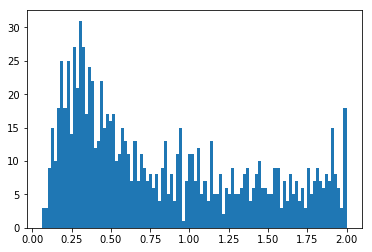

In [58]:
%pylab inline
plt.hist(lst,bins=100);
print np.mean(lst) 

In [59]:
i=1233
u=Y[i][:60]
v=a[i]
plt.plot(u)
plt.plot(v)
print np.median(u),np.median(v), (2*np.abs(u-v)/(np.abs(u)+np.abs(v))).mean()

2862.5 4340.9 0.819918


In [60]:
daily_data.shape,attrib_data.shape

((145063, 256), (145063, 12))

In [61]:
daily_test=daily_data[:,-LEN1:]
attrib_test=attrib_data
daily_test.shape,attrib_test.shape

((145063, 128), (145063, 12))

In [62]:
feed_dict={x:daily_test,x2:attrib_test}
predTest=sess.run(prediction,feed_dict=feed_dict)
predTest.shape

(145063, 60)

In [63]:
predTest=np.round(predTest,1)
np.mean(predTest<1)

0.0001130543281195067

In [64]:
import datetime
cols=pd.date_range(pd.datetime.date(datetime.datetime(2017, 1, 1)), periods=60).map(lambda u: u.strftime("%Y-%m-%d"))
idx=pd.read_csv("../input/train_1.csv",usecols=[0])["Page"]
idx.shape

(145063,)

In [65]:
submission=pd.DataFrame(predTest,columns=cols,index=idx)
submission=submission.unstack().reset_index()
submission['name']=submission.apply(lambda r: r['Page']+"_"+r['level_0'],axis=1)
submission=submission.drop(['Page','level_0'],axis=1)
submission.columns=['Visits','name']

In [66]:
submission=submission[["name",'Visits']]
submission.head()

name     Visits
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...  18.299999
1  2PM_zh.wikipedia.org_all-access_spider_2017-01-01  18.900000
2   3C_zh.wikipedia.org_all-access_spider_2017-01-01   4.900000
3  4minute_zh.wikipedia.org_all-access_spider_201...  13.600000
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  10.300000

In [67]:
keys=pd.read_csv("../input/key_1.csv",index_col=0)

In [68]:
keys_dict=keys["Id"].to_dict()

In [69]:
submission["Id"]=submission["name"].apply(lambda u:keys_dict[u])

In [70]:
submission.isnull().sum().sum()

0L

In [71]:
submission.head()

name     Visits            Id
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...  18.299999  ff8c1aade3de
1  2PM_zh.wikipedia.org_all-access_spider_2017-01-01  18.900000  3da6fd5b23c1
2   3C_zh.wikipedia.org_all-access_spider_2017-01-01   4.900000  cd9e83803be4
3  4minute_zh.wikipedia.org_all-access_spider_201...  13.600000  65cd4af0968c
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  10.300000  75bae1fb2637

In [72]:
submission[["Id","Visits"]].to_csv("../submission/sub_pred_lstm1_60_512_nozero_xnopad_nolog.csv.gz",
                                   index=None, float_format='%.1f', compression="gzip")